In [2]:
# main kütüpler
import pandas as pd
import numpy as np

# Görselleştirme kütüphaneleri 
import seaborn as sea
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split # Veriyi bölmek için
from sklearn.preprocessing import LabelEncoder       # Yazıyı sayıya çevirmek için
from sklearn.neighbors import KNeighborsClassifier   # KNN Algoritması
from sklearn.neural_network import MLPClassifier     # Yapay Sinir Ağı
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # Puanlama

from mpl_toolkits.mplot3d import Axes3D  # 3D Çizim için gerekli

from sklearn.ensemble import RandomForestClassifier # Özellik önemi için

data = pd.read_csv(r"C:\Users\ACER\Downloads\stars\Stars.csv")

data.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0


In [12]:
# Veri Seti Hakkında İstatistiksel Özet
print(" Veri Seti Genel Bilgisi:")
data.info()

print("\nSayısal Verilerin İstatistiksel Özeti")
# Bu kod; ortalama sıcaklık, en büyük yarıçap gibi bilgileri dökmeni sağlar.
print(data.describe().T) # .T harfi tabloyu yan çevirip daha okunaklı yapar

data.columns

 Veri Seti Genel Bilgisi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     240 non-null    int64  
 1   L               240 non-null    float64
 2   R               240 non-null    float64
 3   A_M             240 non-null    float64
 4   Color           240 non-null    int32  
 5   Spectral_Class  240 non-null    int32  
 6   Type            240 non-null    int64  
dtypes: float64(3), int32(2), int64(2)
memory usage: 11.4 KB

Sayısal Verilerin İstatistiksel Özeti
                count           mean            std         min          25%  \
Temperature     240.0   10497.462500    9552.425037  1939.00000  3344.250000   
L               240.0  107188.361635  179432.244940     0.00008     0.000865   
R               240.0     237.157781     517.155763     0.00840     0.102750   
A_M             240.0       4.382396      10.

Index(['Temperature', 'L', 'R', 'A_M', 'Color', 'Spectral_Class', 'Type'], dtype='object')

In [3]:
le = LabelEncoder()

# Renk ve Sınıf sütunlarının sayıya çevrilmesi gerek.
#  Color ve Spectral_Class
data['Color'] = le.fit_transform(data['Color'])
data['Spectral_Class'] = le.fit_transform(data['Spectral_Class'])

print("Dönüştürme Tamamlandı! Veriler artık sayısal.")

Dönüştürme Tamamlandı! Veriler artık sayısal.


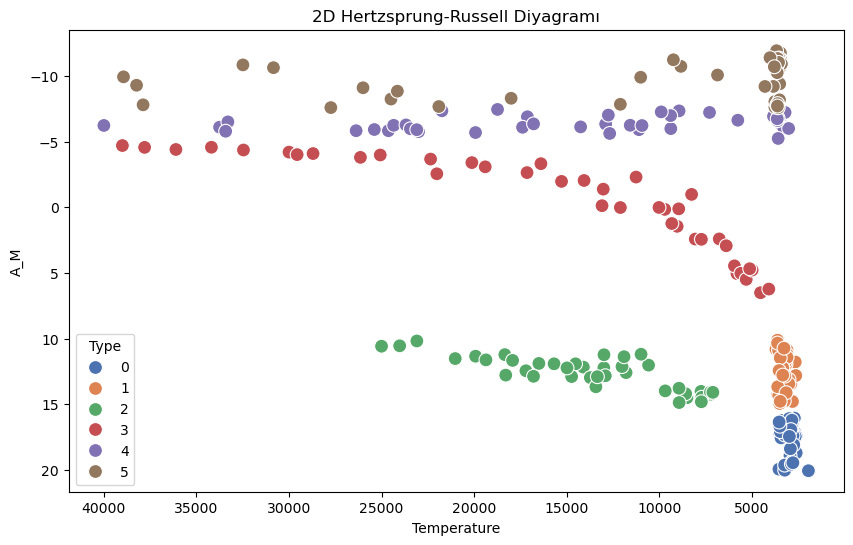

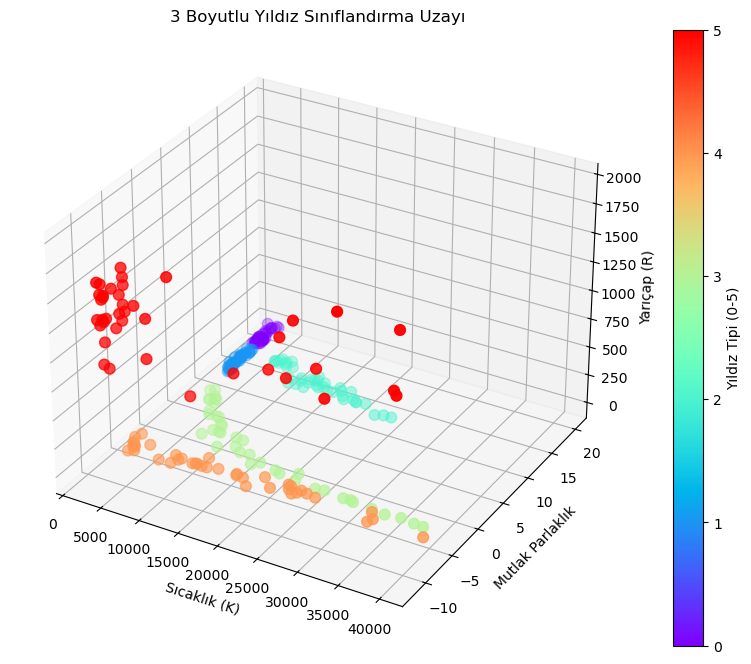

In [4]:
# 1. Klasik H-R Diyagramı (2D)
plt.figure(figsize=(10, 6))
sea.scatterplot(x="Temperature", y="A_M", hue="Type", data=data, palette="deep", s=100)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.title("2D Hertzsprung-Russell Diyagramı")
plt.show()

#  3 Boyutlu Analiz ---
#  yarıçapı da işin içine katarak uzayda nasıl dağıldıklarına baktım.
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# X: Sıcaklık, Y: Mutlak Parlaklık, Z: Yarıçap (R)
img = ax.scatter(data['Temperature'], data['A_M'], data['R'], c=data['Type'], cmap='rainbow', s=60)

ax.set_xlabel('Sıcaklık (K)')
ax.set_ylabel('Mutlak Parlaklık')
ax.set_zlabel('Yarıçap (R)')
ax.set_title('3 Boyutlu Yıldız Sınıflandırma Uzayı')
fig.colorbar(img, label="Yıldız Tipi (0-5)")
plt.show()

In [5]:
y = data['Type']
X = data.drop(['Type'], axis=1)

# %70 Eğitim, %30 Test olarak ayırdım 80 20 olsaydı çok az train verisi olacaktı...
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

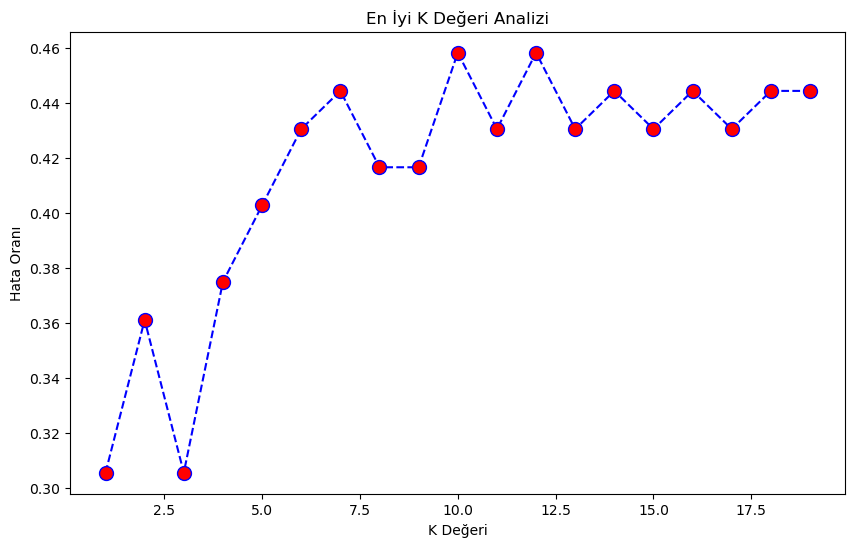

Grafikte hata oranının en düşük olduğu K değerini modelde kullanacağız


In [7]:
#  KNN Optimizasyonu
# 1'den 20'ye kadar tüm komşu sayılarını deneyip en az hata yapanı buluyoruz.
hata_oranlari = []

for i in range(1, 20):
    knn_test = KNeighborsClassifier(n_neighbors=i)
    knn_test.fit(X_train, y_train)
    pred_i = knn_test.predict(X_test)
    hata_oranlari.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), hata_oranlari, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title("En İyi K Değeri Analizi")
plt.xlabel("K Değeri")
plt.ylabel("Hata Oranı")
plt.show()
print("Grafikte hata oranının en düşük olduğu K değerini modelde kullanacağız")

In [9]:
from sklearn.model_selection import cross_val_score
# 1. KNN MODELİ (Optimize Edilmiş) 
knn = KNeighborsClassifier(n_neighbors=3) # Grafiğe göre 3 seçtik
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("KNN Test Başarısı:", accuracy_score(y_test, y_pred_knn))

#  Çapraz Doğrulama
# Modeli 10 farklı testten geçiriyoruz
cv_scores = cross_val_score(knn, X, y, cv=10)
print(f"KNN 10-Katlı Çapraz Doğrulama Ortalaması: %{cv_scores.mean()*100:.2f}")


# --- 2. MLP (YAPAY SİNİR AĞI) MODELİ ---
mlp = MLPClassifier(max_iter=600, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

print("\nMLP Test Başarısı:", accuracy_score(y_test, y_pred_mlp))

KNN Test Başarısı: 0.6944444444444444
KNN 10-Katlı Çapraz Doğrulama Ortalaması: %68.75

MLP Test Başarısı: 0.3333333333333333


C:\Users\ACER\AppData\Local\Temp\ipykernel_15296\3436816596.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sea.barplot(x=onem_dereceleri, y=onem_dereceleri.index, palette="viridis")


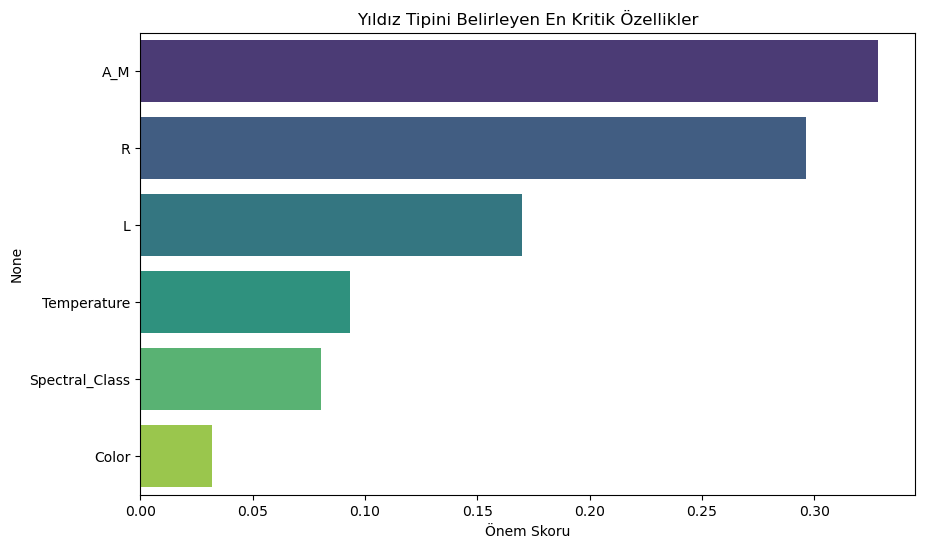

Yorum: Görüldüğü gibi 'Mutlak Parlaklık' ve 'Yarıçap' en belirleyici özelliklerdir.


In [10]:
# Hangi Özellik Daha Önemli? ---
# Random Forest kullanarak özelliklerin ağırlığını hesaplıyoruz neden?
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

onem_dereceleri = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sea.barplot(x=onem_dereceleri, y=onem_dereceleri.index, palette="viridis")
plt.title("Yıldız Tipini Belirleyen En Kritik Özellikler")
plt.xlabel("Önem Skoru")
plt.show()

print("Görüldüğü gibi 'Mutlak Parlaklık' ve 'Yarıçap' en belirleyici özelliklerdir.")

In [13]:
# Denemek amacıyla güneşi aldım. güneş: [Temp=5778, L=1, R=1, A_M=4.83, Color=10, Spectral=5]
gunes = [[5778, 1, 1, 4.83, 10, 5]]

tahmin = knn.predict(gunes)

print(f"Yapay Zeka Güneş Tahmini: Tip {tahmin[0]}")

if tahmin[0] == 3:
    print("SONUÇ: DOĞRU! Güneş Ana Kol (Main Sequence) yıldızıdır.")
else:
    print("Hatalı Tahmin.")

Yapay Zeka Güneş Tahmini: Tip 3
SONUÇ: DOĞRU! Güneş Ana Kol (Main Sequence) yıldızıdır.


C:\Users\ACER\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
